In [17]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix
P = 10 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits
allCarriers = np.arange(K)
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

In [18]:
# For convenience of channel estimation, let's make the last carriers also be a pilot

pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
print(pilotCarriers)
P = P+1
# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
mu = 4 # bits per symbol (i.e. 16PSK)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol
mapping_table = {
    (0,0,0,0) : np.cos(0*np.pi/8)+1j*np.sin(0*np.pi/8),
    (0,0,0,1) : np.cos(np.pi/8)+np.sin(np.pi/8)*1j,
    (0,0,1,0) : np.cos(np.pi/4)+np.sin(np.pi/4)*1j,
    (0,0,1,1) : np.cos(3*np.pi/8)+np.sin(3*np.pi/8)*1j,
    (0,1,0,0) : np.cos(4*np.pi/8)+np.sin(4*np.pi/8)*1j,
    (0,1,0,1) : np.cos(5*np.pi/8)+np.sin(5*np.pi/8)*1j,
    (0,1,1,0) : np.cos(6*np.pi/8)+np.sin(6*np.pi/8)*1j,
    (0,1,1,1) : np.cos(7*np.pi/8)+np.sin(7*np.pi/8)*1j,
    (1,0,0,0) : np.cos(8*np.pi/8)+np.sin(8*np.pi/8)*1j,
    (1,0,0,1) : np.cos(9*np.pi/8)+np.sin(9*np.pi/8)*1j,
    (1,0,1,0) : np.cos(10*np.pi/8)+np.sin(10*np.pi/8)*1j,
    (1,0,1,1) : np.cos(11*np.pi/8)+np.sin(11*np.pi/8)*1j,
    (1,1,0,0) : np.cos(12*np.pi/8)+np.sin(12*np.pi/8)*1j,
    (1,1,0,1) : np.cos(13*np.pi/8)+np.sin(13*np.pi/8)*1j,
    (1,1,1,0) : np.cos(14*np.pi/8)+np.sin(14*np.pi/8)*1j,
    (1,1,1,1) : np.cos(15*np.pi/8)+np.sin(15*np.pi/8)*1j
}
demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1, 0, 0.1+0.1j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)

#serial to parallel
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
def removeCP(signal):
    return signal[CP:(CP+K)]
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    return Hest

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
def get_payload(equalized):
    return equalized[dataCarriers]
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision
def PS(bits):
    return bits.reshape((-1,))

[ 0  6 12 18 24 30 36 42 48 54 60 63]


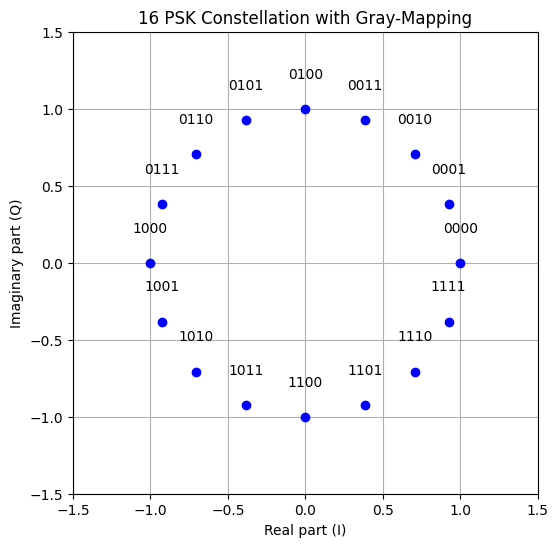

In [19]:

plt.figure(figsize=(6,6))
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.grid(True)
plt.xlim((-1.5, 1.5)); plt.ylim((-1.5,1.5)); plt.xlabel('Real part (I)'); plt.ylabel('Imaginary part (Q)')
plt.title('16 PSK Constellation with Gray-Mapping');

Text(0.5, 0, 'n')

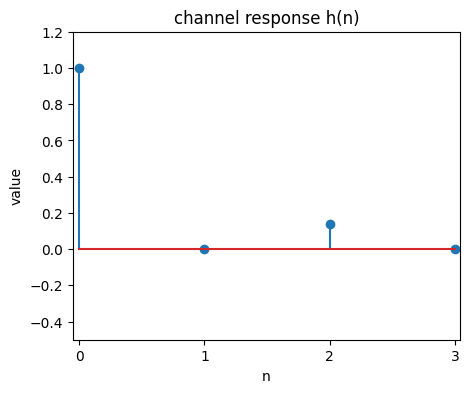

In [20]:
plt.figure(figsize=([5,4]))
channelResponsee = np.array([1, 0, 0.1+0.1j,0])
plt.stem(abs(channelResponsee))
plt.xticks([  0 , 1 , 2, 3])
plt.xlim((-0.05, 3.04)); plt.ylim((-0.5,1.2)); plt.title('channel response h(n)');plt.ylabel('value');plt.xlabel('n')

In [31]:

BER=[]
for SNRdb in np.arange(0, 30, 1):
  bits=np.random.binomial(n=1, p=0.5, size=(13728*50, ))
  QAM_est=[]
  for i in range(0,len(bits),payloadBits_per_OFDM):
    ofdm_sym=bits[i:i+payloadBits_per_OFDM]
  #print(len(ofdm_sym))
    bits_SP = SP(ofdm_sym)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
  #channel
    convolved = np.convolve(OFDM_TX, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    OFDM_RX =convolved + noise
    OFDM_RX_noCP = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_noCP)
    Hest = channelEstimate(OFDM_demod)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est.append(get_payload(equalized_Hest))
  combined_arr = np.concatenate(QAM_est)
  QAM_est= combined_arr.tolist()
  QAM_est=np.array(QAM_est)
  PS_est, hardDecision = Demapping(QAM_est)
  bits_est = PS(PS_est)
  BER.append(np.sum(abs(bits-bits_est))/len(bits))
  print (" BER : ",np.sum(abs(bits-bits_est))/len(bits))


 BER :  0.4312062937062937
 BER :  0.42206439393939393
 BER :  0.4104705710955711
 BER :  0.3981497668997669
 BER :  0.38462412587412587
 BER :  0.3680128205128205
 BER :  0.3527185314685315
 BER :  0.3342395104895105
 BER :  0.3168822843822844
 BER :  0.29577651515151515
 BER :  0.2745906177156177
 BER :  0.2547275641025641
 BER :  0.23219988344988346
 BER :  0.20800553613053613
 BER :  0.18363344988344987
 BER :  0.15939539627039628
 BER :  0.13411858974358976
 BER :  0.10793414918414919
 BER :  0.08389131701631701
 BER :  0.063125
 BER :  0.043723776223776226
 BER :  0.02870483682983683
 BER :  0.0172027972027972
 BER :  0.009775641025641026
 BER :  0.004568764568764569
 BER :  0.0019624125874125875
 BER :  0.0007604895104895105
 BER :  0.00021853146853146853
 BER :  5.973193473193473e-05
 BER :  1.3111888111888112e-05


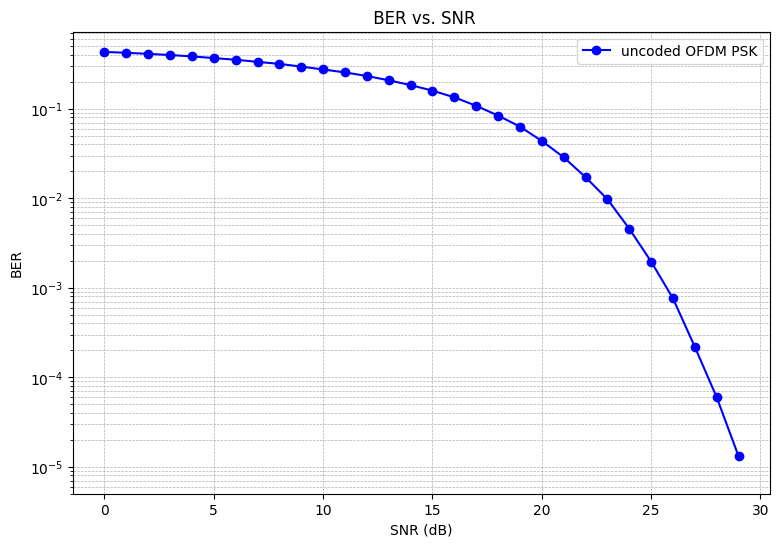

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Given SNR values and corresponding BER values
SNRdb = np.arange(0, 30, 1)  # SNR from 0 to 32 in steps of 2
BER1=BER

# Create a semilogy plot
plt.figure(figsize=(9, 6))
plt.semilogy(SNRdb, BER1, marker='o', linestyle='-', color='b')
plt.title(' BER vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks([0,5,10,15,20,25,30])  # Set x-ticks to the SNR values
plt.ylim(bottom=5e-6)  # Set a lower limit for the y-axis to enhance visibility
plt.legend(['uncoded OFDM PSK'])
plt.show()

(0.0, 1.4)

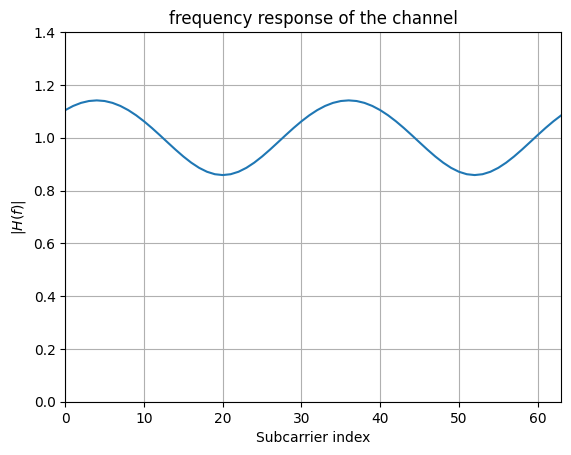

In [8]:
plt.plot(allCarriers, abs(H_exact))
plt.xlabel('Subcarrier index'); plt.ylabel('$|H(f)|$'); plt.grid(True); plt.xlim(0, K-1);plt.title('frequency response of the channel')
plt.ylim(0, 1.4)

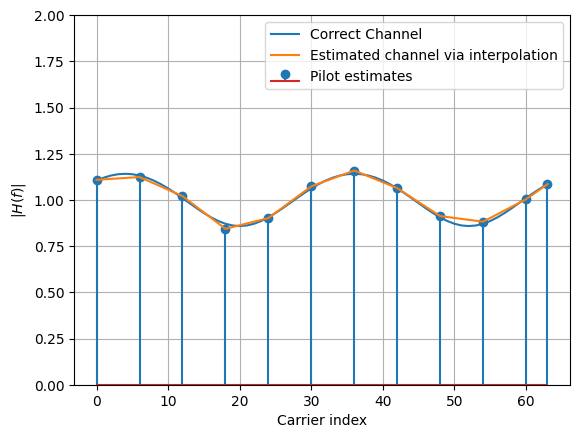

In [9]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)

    return Hest
Hest = channelEstimate(OFDM_demod)